In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import math

In [2]:
#load ground truth

data = sio.loadmat('T4_J7_U15_R111111_N100.mat') #ground truth data

signalarray = data['a']
infoarray = data['b']
configarray = data['c']

signalarray = signalarray[0].tolist()
infoarray = infoarray[0].tolist()
configarray = configarray[0].tolist()


spiketimes = []
for spike in range(len(infoarray)):
    spiketimes.append(infoarray[spike][0][0].tolist())

n_spiketimes = []
for spike_no in range(len(spiketimes)):
    for spike in range(len(spiketimes[spike_no])):
        tmp = [spiketimes[spike_no][spike],int(spike_no+1)]
        n_spiketimes.append(tmp)

ground_truth = n_spiketimes;
ground_truth.sort(key=lambda x:x[0],reverse=False)


In [3]:
#load guess
guess = pd.read_excel('T4_J7_U15_R111111_N100_VS.xls')
guess = guess[['Timestamp','Unit']]
guess = guess.values.tolist()

offset = -0.0015

for i in range(len(guess)):
    guess[i][1] = int(guess[i][1])
    guess[i][0] = guess[i][0] + offset


In [4]:



#x = target, y = base
threshold = 0.0005; 

def AssociationMatrix(target_array,guess_array):
    assocMatrix = [[0 for x in range(len(target_array))] for y in range(len(guess_array))] 
    #x = target, y=guess
    for targetspike in range(len(target_array)):
        for guessspike in range(len(guess_array)):
            v=abs(target_array[targetspike][0] - guess_array[guessspike][0])
            assocMatrix[guessspike][targetspike] = v
            
    #get associated value until no more can be associated
    assocArray = []
    while True:
        targetcoord = -1;
        guesscoord = -1;
        minvalue = -1;
 
        for targetspike in range(len(target_array)):
            for guessspike in range(len(guess_array)):
                val = assocMatrix[guessspike][targetspike]
                if (val >= 0 and val <= threshold and ( (minvalue == -1 ) or val < minvalue)):
                    targetcoord = targetspike;
                    guesscoord = guessspike;
                    minvalue = val;
        if minvalue == -1:
            break
        assocArray.append([target_array[targetcoord][0],guess_array[guesscoord][1]])
        for targetspike in range(len(target_array)):
            assocMatrix[guesscoord][targetspike] = -1
            for guessspike in range(len(guess_array)):
                assocMatrix[guessspike][targetcoord] = -1
        
    return assocArray





In [5]:
no_of_buckets = 200

guess_group = np.array_split(guess, no_of_buckets)

#[min,max]

index_bound_group = []

lower = -1
upper = -1

#we've divided up guesses for processing

#this function divides up target values in equivalent chunks by finding the bounds of indexes for each group
for i in range(len(guess_group)):
    lower = max(upper-1,0);
    upper_target_val = guess_group[i][-1][0]
    for j in range(lower, len(ground_truth)):
        if (ground_truth[j][0] > upper_target_val):
            break
    upper = j;
    index_bound_group.append([lower,upper])

#[start_row_index:end_row_index, start_column_index:end_column_index]
full_assoc = [];

for i in range(no_of_buckets):
    start_row_index = index_bound_group[i][0]
    end_row_index = index_bound_group[i][1]
    target_subsection = ground_truth[start_row_index:end_row_index]
    testans = AssociationMatrix(target_subsection,guess_group[i])
    for j in range(len(testans)):
        full_assoc.append(testans[j])
full_assoc.sort(key=lambda x:x[0],reverse=False)
for i in range(len(full_assoc)):
    full_assoc[i][1] = int(full_assoc[i][1])

In [6]:
n_k = len(guess) #guesses
n_GT = len(ground_truth) #ground truth
n_match = len(full_assoc) #
n_miss = n_GT - n_match
n_fp = n_k - n_match

precision = n_match / n_k # precision = 1 - (false positive rate).
recall = n_match/n_GT # recall = 1 - (false negative rate).
accuracy = n_miss/(n_match+n_miss+n_fp)

print("Precision",precision,"Recall",recall,"Accuracy",accuracy)


print(full_assoc)

Precision 0.5066201076676852 Recall 0.38081697380652924 Accuracy 0.4516733814671507
[[0.10285714285714286, 2], [0.13749999999999998, 2], [0.14857142857142858, 2], [0.1875, 2], [0.19428571428571428, 2], [0.225, 2], [0.2571428571428571, 2], [0.275, 2], [0.3142857142857143, 2], [0.32, 2], [0.3657142857142857, 2], [0.41714285714285715, 2], [0.45, 2], [0.46285714285714286, 2], [0.6228571428571429, 2], [0.6514285714285715, 2], [0.6914285714285715, 2], [0.742857142857143, 2], [0.7771428571428572, 2], [0.8057142857142858, 2], [0.8342857142857144, 2], [0.875, 2], [0.8800000000000001, 2], [0.9085714285714287, 2], [0.9257142857142858, 2], [0.9375, 2], [0.9600000000000001, 2], [0.982857142857143, 2], [1.0125, 2], [1.0628571428571432, 2], [1.1028571428571432, 2], [1.1542857142857146, 2], [1.2171428571428575, 2], [1.2742857142857147, 2], [1.2999999999999998, 2], [1.3200000000000005, 2], [1.3600000000000005, 2], [1.3624999999999998, 2], [1.3942857142857148, 2], [1.4, 2], [1.4228571428571433, 2], [1.4

In [20]:
def compare(final_target,final_assoc):
    targ_range = -1
    assoc_range = -1
    for x in range(len(final_target)):
        targ_range = max(final_target[x][1],targ_range)
    for y in range(len(final_assoc)):
        assoc_range = max(final_assoc[y][1],assoc_range)
    assocMatrix = [[0 for x in range(targ_range)] for y in range(assoc_range+1)] 
    targ_pointer = 0
    assoc_pointer = 0
    
    false_spike = 0
    missed_spike = 0
    matched_spike = 0
    while (targ_pointer < len(final_target) and assoc_pointer < len(final_assoc)):
        if (final_target[targ_pointer][0] == final_assoc[assoc_pointer][0]):
            
            assocMatrix[final_assoc[assoc_pointer][1]][final_target[targ_pointer][1]-1] += 1
            matched_spike += 1
            targ_pointer += 1
            assoc_pointer += 1
        elif (final_target[targ_pointer][0] < final_assoc[assoc_pointer][0]):
            targ_pointer += 1
            missed_spike += 1
        else:
            assoc_pointer += 1
            false_spike += 1
    
    for y in range(len(assocMatrix)):
        sum = 0
        for x in range(len(assocMatrix[y])):
            sum += assocMatrix[y][x]
        for x in range(len(assocMatrix[y])):
            assocMatrix[y][x] = assocMatrix[y][x]/sum
        
    return assocMatrix

    
        

In [21]:

ppp = compare(ground_truth,full_assoc)
print(ppp)


[[0.0, 0.0, 0.0, 1.0], [0.11711711711711711, 0.8378378378378378, 0.021021021021021023, 0.024024024024024024], [0.05885029576823904, 0.007432124981040497, 0.23934475959350826, 0.6943728196572122]]


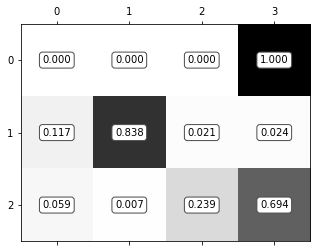

[[0.0, 0.0, 0.0, 1.0], [0.11711711711711711, 0.8378378378378378, 0.021021021021021023, 0.024024024024024024], [0.05885029576823904, 0.007432124981040497, 0.23934475959350826, 0.6943728196572122]]


In [22]:
import matplotlib.pyplot as plt
import numpy as np



fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(ppp, cmap='Greys')

for (i, j), z in np.ndenumerate(ppp):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

plt.show()
print(ppp)